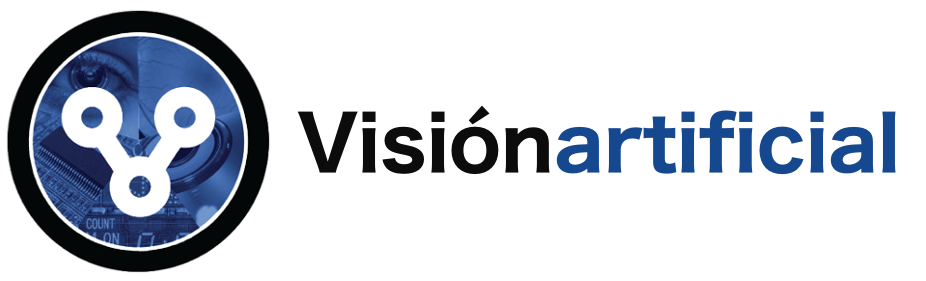

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# 2.1 Ferramentas matemáticas para a formación de imaxes: Transformacións homoxéneas


As transformacións homoxéneas (tamén chamadas proxectivas) son transformacións lineais (é dicir, multiplicacións de matrices) **entre coordenadas homoxéneas** (vectores). Tales coordenadas obtéñense de vectores cartesianos (non homoxéneos) **ampliándoas cun número non negativo** (normalmente 1, por comodidade).

Aínda que imos explicar as transformacións homoxéneas usando o espazo 3D, **isto é xeneralizable a calquera outro número de dimensións**.

Un vector 3D (ou un punto 3D) en **coordenadas non homoxéneas**:

$$\mathbf{x} = \begin{bmatrix} x \\ y \\ z \end{bmatrix} \in \mathbb{R}^3$$

mentres que o mesmo vector en **coordenadas homoxéneas** ten a forma (nótese a tilde na notación):

$$\mathbf{\tilde{x}} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} \equiv \begin{bmatrix} \lambda x \\ \lambda y \\ \lambda z \\ \lambda \end{bmatrix} \in \mathbb{R}^4$$

Podemos retroceder dividindo as tres primeiras coordenadas pola cuarta:$\\[5pt]$

$$\mathbf{\tilde{x}} = \begin{bmatrix} \lambda x \\ \lambda y \\ \lambda z \\ \lambda \end{bmatrix} \Rightarrow \mathbf{x} = \begin{bmatrix} x/\lambda \\ y/\lambda \\ z/\lambda \end{bmatrix} \in \mathbb{R}^3$$

Deste xeito, a familia de vectores homoxéneos con $\lambda \neq 0$ representa o mesmo punto en $\mathbb{R}^3$, xa que $\lambda$ non afecta. Outra consecuencia de $\lambda$ é que **calquera transformación en coordenadas homoxéneas vale para calquera matriz escalada**:
  
$$
\begin{bmatrix} x_1' \\ x_2' \\ x_3' \\ x_4' \end{bmatrix} 
= 
\begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \\ p_{41} & p_{42} & p_{43} & p_{44} \end{bmatrix} 
\begin{bmatrix} \lambda x_1 \\ \lambda x_2 \\ \lambda x_3 \\ \lambda \end{bmatrix} 
= 
\lambda 
\begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \\ p_{41} & p_{42} & p_{43} & p_{44} \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ 1 
\end{bmatrix} 
$$

Entón, as seguintes transformacións son equivalentes:

$$
\begin{bmatrix} 1 & -3 & 2 & 5 \\ 4 & 2 & 1 & 2 \\ 4 & -1 & 0 & 2 \\ -6 & 2 & 1 & 2 
\end{bmatrix} 
\equiv 
\lambda 
\begin{bmatrix} 1 & -3 & 2 & 5 \\ 4 & 2 & 1 & 2 \\ 4 & -1 & 0 & 2 \\ -6 & 2 & 1 & 2 
\end{bmatrix}
$$

**Esta indeterminación adoita xestionarse corrixindo unha entrada da matriz**, (por exemplo, $p_{44} = 1$). Ademais, estas matrices deben ser non singulares (Rango = 4).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, radians
%matplotlib notebook

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
images_path = './images/'

## 8.2.1 Por que queremos isto? 1ª Razón 

Agora que sabemos como funcionan as coordenadas homoxéneas e as transformacións homoxéneas, é hora de entender **por que isto é interesante**.

Polo momento, estivemos a realizar transformacións completas (rotacións e translacións) utilizando unha matriz de rotación e engadindo un vector de translación aos puntos xirados ($\mathbf{p}' = \mathbf{R}\mathbf{p} + \mathbf{ t}$).

O problema desta transformación é que a **concatenación de transformacións** cando hai que facer unha secuencia de transformacións convértese nun desastre:

$\hspace{2cm} \mathbf{p}' = \mathbf{R}_1\mathbf{p}+\mathbf{t}_1 \\ \hspace{2cm} \mathbf{p}'' = \mathbf{R}_2\mathbf{p}' + \mathbf{t}_2 = \mathbf{R}_2(\mathbf{R}_1\mathbf{p}+\mathbf{t}_1) + \mathbf{t}_2 = \mathbf{R}_2\mathbf{R}_1\mathbf{p} + \mathbf{R}_2\mathbf{t}_1 + \mathbf{t}_2$

No contexto do noso problema, cada vez que movemos a cámara temos que concatenar unha nova transformación. Imaxina isto nun videoxogo en primeira persoa, onde se necesita unha transformación do sistema de coordenadas en cada fotograma. En só un segundo deberían calcularse máis de 60 concatenacións!

**Que pasa se usamos coordenadas homoxéneas?**

Podemos expresar unha transformación consistente nunha rotación + translación usando só unha multiplicación matricial:

$$ \mathbf{\tilde{p}}' = \mathbf{T}_1\mathbf{\tilde{p}} \Rightarrow \begin{bmatrix} x' \\ y' \\ z' \\ 1 \end{bmatrix} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x\\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} = \begin{bmatrix} r_{11}x + r_{12}y + r_{13}z + t_x \\ r_{21}x + r_{22}y + r_{23}z + t_y \\ r_{31}x + r_{32}y + r_{33}z + t_z \\ 0x + 0y + 0z + 1 \end{bmatrix} = \begin{bmatrix} r_{11}x + r_{12}y + r_{13}z \\ r_{21}x + r_{22}y + r_{23}z \\ r_{31}x + r_{32}y + r_{33}z \\ 1 \end{bmatrix} +  \begin{bmatrix} t_x \\ t_y \\ t_z \\ 0 \end{bmatrix}$$

Teña en conta que a submatriz superior esquerda 3$\times$3 da matriz $\mathbf{T}_1$ é unha matriz de rotación mentres que a última columna contén a tradución desexada.
Esta é a razón principal para usar coordenadas homoxéneas, mira **como se aplica a concatenación agora!**

$\hspace{02cm}  \mathbf{\tilde{p}}' = \mathbf{T}_1\mathbf{\tilde{p}} \\
 \hspace{2cm}  \mathbf{\tilde{p}}'' = \mathbf{T}_2\mathbf{\tilde{p}}' = \mathbf{T}_2\mathbf{T}_1\mathbf{\tilde{p}}$
 
**A concatenación faise moito máis doada**, sendo só multiplicacións matriciais consecutivas (lembremos que, hoxe en día, as multiplicacións matriciais son moi rápidas utilizando as GPU).


**Imos a Xoguar un pouco con coordenadas homoxéneas**. Imos aplicar unha transformación homoxénea a un obxecto 3D (un conxunto de puntos 3D, de feito). Para iso, definimos `data`$\in \mathbb{R}^4$, unha **matriz que contén máis de 3k puntos en coordenadas homoxéneas**:

<IPython.core.display.Javascript object>


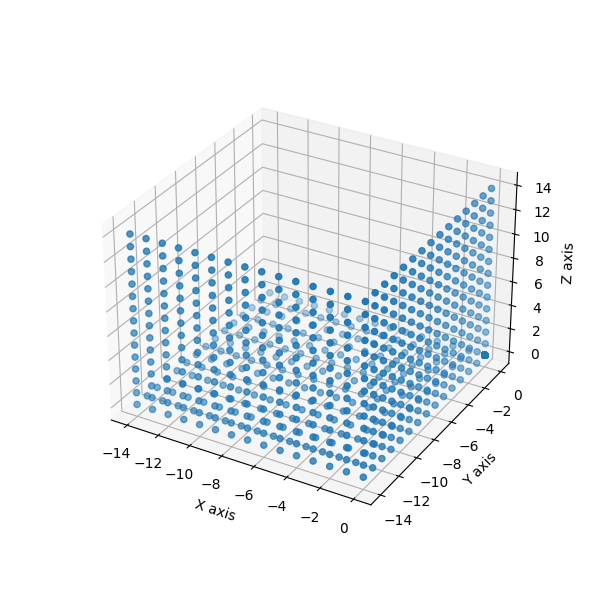

In [2]:
# Cargamos os datos
data = np.load("./data/data.npy")

# Creamos a figura e preparamola para 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Nomes eixes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# representamos os puntos
ax.scatter(data[0,:], data[1,:], data[2,:])

fig.show()

## **<span style="color:green"><b><i>TAREA 1: Transformacións homoxéneas para gañar</i></b></span>**

Agora, crea un novo método chamado `apply_homogeneous_transformation()` que constrúe unha matriz homoxénea a partir dalgúns valores *yaw*, *pitch* e *roll*, así como un vector de tradución e aplícaa á matriz de datos de entrada `data`. *Ten en conta que non estamos transformando vectores, senón puntos, así que use [`scatter()`](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html) en lugar de `quiver()`.*

Observa que, ao contrario do caso euclidiano, aquí tanto a rotación como a traslación aplícanse só cunha multiplicación matricial! (`t` no seguinte código).

Lembra as matrices que definen as rotacións elementais:

$\hspace{2cm}\mathbf{R}_z(\theta) = \begin{bmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \\ 0 & 0 & 1 \end{bmatrix} \hspace{1cm} \mathbf{R}_y(\theta) = \begin{bmatrix} cos\theta & 0 & sin\theta \\ 0 & 1 & 0 \\ -sin\theta & 0 & cos\theta \end{bmatrix} \hspace{1cm} \mathbf{R}_x(\theta) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & cos\theta & -sin\theta \\ 0 & sin\theta & cos\theta \end{bmatrix}\\[5pt]$


In [3]:
# TAREFA 7
def apply_homogeneous_transformation(data, yaw, pitch, roll, translation):
    
    
    """ Aplica unha transformación lineal a un conxunto de vectores 3D e representaos
        
         Args:
             datos: conxunto de puntos de entrada a transformar
             yaw: graos para xirar o sistema de coordenadas arredor do eixe "Z".
             pitch: graos para xirar o sistema de coordenadas arredor do eixe "Y".
             roll: graos para xirar o sistema de coordenadas ao redor do eixe "X".
             translation: vector columna que contén a translación para cada eixe
     """

    # Escribe aqui o teu codigo!
    
    # Transformamos a radians
    yaw = radians(yaw)
    pitch = radians(pitch)
    roll = radians(roll)
    
    # Construimos as matrices de rotacion
    Rx = np.array([[1,0,0],[0,np.cos(roll),-np.sin(roll)],[0,np.sin(roll),np.cos(roll)]])
    Ry = np.array([[np.cos(pitch),0,np.sin(pitch)],[0,1,0],[-np.sin(pitch),0,np.cos(pitch)]])
    Rz = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])
    
    # Combiana as materias de rotacion
    R = Rz@Ry@Rx
    
    # Creamos as matrices homoxeneas de transforamción
    t = np.zeros((4,4))
    t[0:3,0:3] = R
    t[0:3,3] = translation
    t[3,3] = 1
    transformed = t@data
    
    # Creamos a figura e preparamola para 3D
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    #Nome eixos
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # representamos o puntos
    ax.scatter(transformed[0], transformed[1], transformed[2])

    fig.show()

Agora apliqca a seguinte transformación ao obxecto cargado anteriormente:

- Rotación **Yaw**: 45 graos
- Rotación **Pitch**: -60 graos
- Rotación **Roll**: 20 graos
- **Translación**:
     - Eixe $X$: 20 unidades
     - Eixe $Y$: 20 unidades
     - Eixe $Z$: 40 unidades

Lembra que só se realizará mediante unha transformación homoxénea (unha multiplicación matricial única)!

<IPython.core.display.Javascript object>


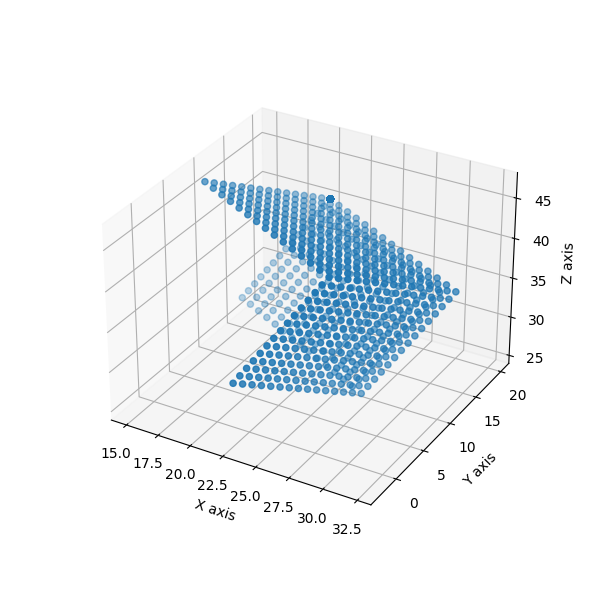

In [4]:
# Cargamos os datos
data = np.load("./data/data.npy")

# Aplicamos a transformacion
apply_homogeneous_transformation(data, 45, -60, 20, [20,20,40])

<font color='blue'>**Saída correcta:**  </font>

<img src="./images/example_transformation_5b.png" width="500" align="left"/>
<img src="./images/blank.png" width="100" align="rigth"/>

Ao facer estas transformacións, o noso motor gráfico podería representar obxectos en movemento no "MUNDO" cando o xogador está inmóbil (por exemplo, paxaros voadores, coches, outros xogadores, etc.).

### Extra: tempo de execución

Só como curiosidade, comprobemos canto tempo necesita python para aplicar unha transformación tanto en coordenadas euclidianas como homoxéneas. *Nota: ten coidado coa lonxitude, se é demasiado grande podería colgar o ordenador!*

In [5]:
import time

# Numero de puntos para transformar
length = 60000000 

# Peparamos os datos en coordenas Euclideas
Pts = np.random.rand(3,length)
R = np.random.rand(3,3)
T = np.random.rand(3,1)

# Peparamos os datos en coordenas Homoxeneoas
Ones = np.ones(length)
Pts_H = np.row_stack((Pts,Ones))
T_H = np.random.rand(4,4)

# Aplicamos a transformación Euclidea
start_time = time.time()
res = R@Pts+T
print("Tempo investido na transformacion Euclidea: %s segundos ---" % (time.time() - start_time))

# Aplicamos a transformación Homoxenea
start_time = time.time()
res = T_H@Pts_H
print("Tempo investido na transformacion homoxenea: %s segundos ---" % (time.time() - start_time))

Tempo investido na transformacion Euclidea: 0.6294691562652588 segundos ---
Tempo investido na transformacion homoxenea: 0.4874720573425293 segundos ---


## **<span style="color:green"><b><i>TAREFA 2: como ve o xogador o mundo</i></b></span>**

Un último exemplo, considera a seguinte imaxe, na que o noso personaxe Xoel está mirando un escenario post-apocalíptico distópico.

<img src="./images/tlou.png" width="1200" align="center"/>

O sistema de referencia `MUNDO` móstrase en laranxa e rotulado con {$\mathbf{W}$} mentres que o sistema de referencia da vista do personaxe móstrase en vermello e rotulado como {$\mathbf{C}$}. Sabemos que:

- a posición e orientación de {$\mathbf{C}$} con respecto a {$\mathbf{W}$} vén dado por un ángulo de *yaw* de -45º, un ángulo de *roll* de -90 e unha traslación de \[0,0,-4,0,1,2\] metros nos \[$x$ ,$y$,$z$\] eixes, respectivamente, e
- as coordenadas do punto $\mathbf{p}^W$ no `MUNDO` son \[30.0,1.2,0.5\] metros.

**Poderías calcular** cales son as súas coordenadas segundo o punto de vista do noso personaxe ($\mathbf{p}^C$)? Como veremos en futuros cadernos, coñecer tales coordenadas é vital para obter a posición do punto 3D **na imaxe** que vería Xoel se este xogo fose en primeira persoa (afortunadamente non o é!).

In [6]:
# TAREFA 8
# Escribe aqui o teu codigo
p = np.array([30,1,0.5,1])
p = np.vstack(p)

# Convertimos a radians
yaw = radians(-45)
pitch = radians(0)
roll = radians(-90)

# Consruimos as matrices de rotacion
Rx = np.array([[1,0,0],[0,np.cos(roll),-np.sin(roll)],[0,np.sin(roll),np.cos(roll)]])
Ry = np.array([[np.cos(pitch),0,np.sin(pitch)],[0,1,0],[-np.sin(pitch),0,np.cos(pitch)]])
Rz = np.array([[np.cos(yaw),-np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])

# Combinamos as matrices de rotacion
R = Rz@Ry@Rx

# Creamos a matriz homoxenea de trasnforamcion
t = np.zeros((4,4))
t[0:3,0:3] = R
t[0:3,3] = [0,-4,1.2]
t[3,3] = 1

transformed = np.linalg.inv(t) @ p
print(transformed)

[[17.67766953]
 [ 0.7       ]
 [24.74873734]
 [ 1.        ]]


<font color='blue'>**Saida correcta (homoxeneas):**  </font> 

    [[17.67766953]
     [ 0.7       ]
     [24.74873734]
     [ 1.        ]]

### <font color="blue"><b><i>Reflexionando</i></b></font>

**Agora estás nunha boa posición para responder a estas preguntas:**

- Cal é a lonxitude dun vector cartesiano 3D en coordenadas homoxéneas?

     <p style="margin: 4px 0px 6px 5px; color:blue"><i>4, as 3 que determinan as corrdenas máis a ampliación </i></p>
    
- Cantas operacións necesitas para transformar un punto no sistema de referencia MUNDO ao da cámara utilizando coordenadas euclidianas? e utilizando coordenadas homoxéneas?

     <p style="margin: 4px 0px 6px 5px; color:blue"><i>Usando euclidianas duas, a rotacion (producto matricial) e a traslación (suma), usando homoxeneas se reduce a unha multiplicación matricial.</i></p>
    
- Explicar a diferenza no tempo de execución ao utilizar os dous tipos de transformacións.

     <p style="margin: 4px 0px 6px 5px; color:blue"><i>Coas GPU as multiplicacións matriciais son moi rápidas, polo que se se pode aunar todalas operación nuha multiplicación matricial ahorrarase tempo.</i></p>
    
- Por que se aplican as rotacións nesa orde? Poderíanse aplicar doutro xeito?

     <p style="margin: 4px 0px 6px 5px; color:blue"><i>A orde elixida é a máis utilizada no campo robotico, aínda que se podria utilizar outro orden os resultados non serían os mesmos, xa que o producto matricial non é commutativo</i></p>

## 8.2.2 Por que queremos isto? 2ª Razón

Hai outra razón que xustifica a utilización de coordenadas homoxéneas cando se trata de transformacións: dan como resultado un modelo natural para a cámara, xa que os puntos do plano da imaxe son raios de proxección en $\mathbb{R}^3$.

**En 1D:**

- Coordenadas cartesianas: $x=x_1=3$.
- Coordenadas homoxéneas: $ x = \begin{bmatrix}3 \\ 1\end{bmatrix} \equiv \begin{bmatrix}6 \\ 2\end{bmatrix} \equiv \begin{bmatrix}3k \\ k\end {bmatrix}, \ \ k \neq 0$

Todos os puntos en coordenadas homoxéneas representan o mesmo punto en cartesianos xa que $x=x_1/x_2=3$.

**En 2D:**

- Coordenadas cartesianas: $x=\begin{bmatrix}x_1 \\ x_2\end{bmatrix} \in \mathbb{R}^2$.
- Coordenadas homoxéneas: $ x = k\begin{bmatrix}x_2 \\ x_1 \\ 1\end{bmatrix}, \ \ k \neq 0$

Así, en coordenadas homoxéneas, un punto do plano $\mathbb{R}^2$ transfórmase nunha liña que pasa pola orixe nun marco de referencia paralelo ao plano da imaxe (perpendicular a $x_3$).

<IPython.core.display.Javascript object>


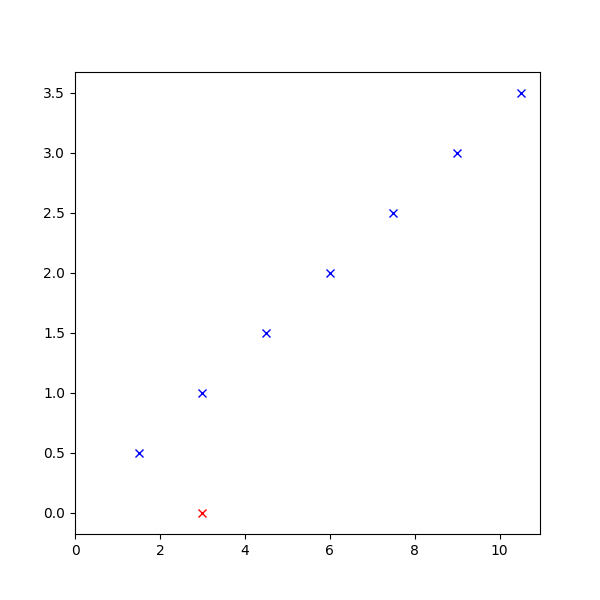

In [7]:
# punto 1D
x1 = 3
plt.figure()
plt.plot(x1,0,'rx')

# Punto en homoxeneas
x = np.array([3,1])

# Puntos equivalentes multiplicando por landa
for lambda_ in np.arange(0.5,4,0.5):
    plt.plot(x[0]*lambda_,x[1]*lambda_,'bx')
    
plt.xlim(0)
plt.show()

## Conclusión


Neste caderno aprendemos:

- Os principios de coordenadas homoxéneas.
- Como xirar e trasladar puntos ou vectores utilizando coordenadas homoxéneas.

Sigamos ...